In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

## PDE 
The VTI wave equation for the square slowness m, thomsen parametersd $\epsilon$ ( and $\delta$ for 3D)  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - (1+2\epsilon)(\frac{d^2 u(x,t)}{dx^2}+ \frac{d^2 u(x,t)}{dy^2}) - \sqrt{(1+2\delta)} \frac{d^2 u(x,t)}{dz^2} =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

In [2]:
p=Function('p')
m,s,h = symbols('m s h')
m=M(x,y)
q=Q(x,y,t)
d=D(x,y,t)
e=E(x,y)

A=epsilon(x,y)
B=delta(x,y)

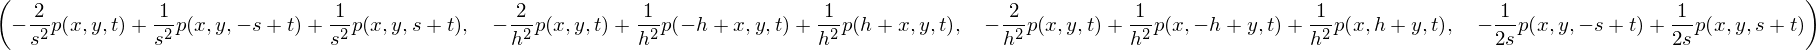

In [3]:
dtt=as_finite_diff(p(x,y,t).diff(t,t), [t-s,t, t+s])
dt=as_finite_diff(p(x,y,t).diff(t), [t-s, t+s])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxx=as_finite_diff(p(x,y,t).diff(x,x), [x-h,x, x+h]) 
dyy=as_finite_diff(p(x,y,t).diff(y,y), [y-h,y, y+h])
dtt,dxx,dyy,dt

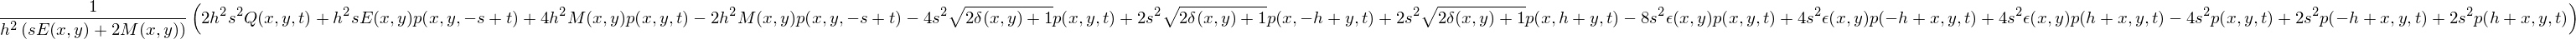

In [19]:
# Forward wave equation (this is 2D so y is z)
wave_equation = m*dtt- (1+2*A)*(dxx)-sqrt(1+2*B)*(dyy) - q  + e*dt
stencil = solve(wave_equation,p(x,y,t+s))[0]
ts=lambdify((p(x,y,t-s), p(x-h,y,t), p(x,y,t), p(x+h,y,t),p(x,y-h,t), p(x,y+h,t), q , m, s, h, A, B, e),stencil,"numpy")
stencil 

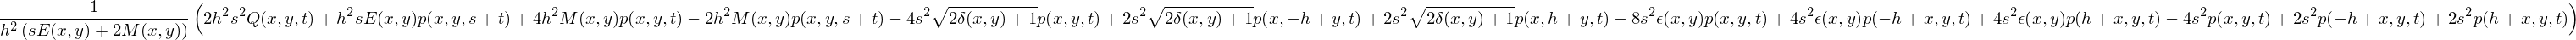

In [20]:
# Adjoint wave equation
wave_equationA = m*dtt- (1+2*A)*(dxx)-sqrt(1+2*B)*(dyy) - q  - e*dt
stencilA = solve(wave_equationA,p(x,y,t-s))[0]
tsA=lambdify((p(x,y,t+s), p(x-h,y,t), p(x,y,t), p(x+h,y,t),p(x,y-h,t), p(x,y+h,t), d , m, s, h, A, B, e),stencilA,"numpy")
stencilA

In [40]:
import matplotlib.pyplot as plt
from matplotlib import animation

hstep=25 #space increment d  = minv/(10*f0);
tstep=2 #time increment dt < .5 * hstep /maxv;
tmin=0.0 #initial time
tmax=600 #simulate until
xmin=-500.0 - 10*hstep #left bound
xmax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
ymin=-500.0 - 10*hstep #left bound
ymax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
f0=.010
t0=1/.010
nbpml=10
nx = int((xmax-xmin)/hstep) + 1 #number of points on x grid
ny = int((ymax-ymin)/hstep) + 1 #number of points on x grid
nt = int((tmax-tmin)/tstep) + 2 #number of points on t grid
xsrc=0
ysrc=0
xrec = nbpml+4
#set source as Ricker wavelet for f0 
def source(x,y,t):
    r = (np.pi*f0*(t-t0))
    val = (1-2.*r**2)*np.exp(-r**2)
    if abs(x-xsrc)<hstep/2 and abs(y-ysrc)<hstep/2:
        return val
    else:
        return 0.0
    
def dampx(x):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if x<nbpml:
        return dampcoeff*((nbpml-x)/nbpml)**2
    elif x>nx-nbpml-1:
        return dampcoeff*((x-nx+nbpml)/nbpml)**2
    else:
        return 0.0
def dampy(y):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if y<nbpml:
        return dampcoeff*((nbpml-y)/nbpml)**2
    elif y>ny-nbpml-1:
        return dampcoeff*((y-ny+nbpml)/nbpml)**2
    else:
        return 0.0

In [41]:
# Velocity models
def smooth10(vel,nx,ny):
    out=np.ones((nx,ny))
    out[:,:]=vel[:,:]
    for a in range(5,nx-6):
        out[a,:]=np.sum(vel[a-5:a+5,:], axis=0) /10
    return out

# True velocity
vel=np.ones((nx,ny)) + 2.0
#vel[floor(nx/2):nx,:]=4.5
mt=vel**-2
# Smooth velocity
v0=smooth10(vel,nx,ny)
m0=v0**-2

dm=m0-mt


eps=np.ones((nx,ny)) -0.7
#eps[floor(nx/2):nx,:]=.3

delt=np.ones((nx,ny)) -0.8
#delt[floor(nx/2):nx,:]=.2


In [42]:
def Forward(nt,nx,ny,m):
    u=np.zeros((nt,nx,ny))
    rec=np.zeros((nt,ny-2))
    for ti in range(0,nt):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                src = source(xmin+a*hstep,ymin+b*hstep,tstep*ti)
                damp=dampx(a)+dampy(b)
                if ti==0:
                    u[ti,a,b]=ts(0,0,0,0,0,0,src,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                elif ti==1:
                    u[ti,a,b]=ts(0,u[ti-1,a-1,b],u[ti-1,a,b],u[ti-1,a+1,b],u[ti-1,a,b-1],u[ti-1,a,b+1],src,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                else:
                    u[ti,a,b]=ts(u[ti-2,a,b],u[ti-1,a-1,b],u[ti-1,a,b],u[ti-1,a+1,b],u[ti-1,a,b-1],u[ti-1,a,b+1],src,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                if a==xrec :
                    rec[ti,b-1]=u[ti,a,b] 
    return rec,u

def Adjoint(nt,nx,ny,m,rec):
    v=np.zeros((nt,nx,ny))
    srca=np.zeros((nt))
    for ti in  range(nt-1, -1, -1):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                if a==xrec:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                damp=dampx(a)+dampy(b)
                if ti==nt-1:
                    v[ti,a,b]=tsA(0,0,0,0,0,0,resid,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                elif ti==nt-2:
                    v[ti,a,b]=tsA(0,v[ti+1,a-1,b],v[ti+1,a,b],v[ti+1,a+1,b],v[ti+1,a,b-1],v[ti+1,a,b+1],resid,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                else:
                    v[ti,a,b]=tsA(v[ti+2,a,b],v[ti+1,a-1,b],v[ti+1,a,b],v[ti+1,a+1,b],v[ti+1,a,b-1],v[ti+1,a,b+1],resid,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                if abs(xmin+a*hstep-xsrc)<hstep/2 and abs(ymin+b*hstep-ysrc)<hstep/2:
                    srca[ti]=v[ti,a,b]
    return srca,v

def Gradient(nt,nx,ny,m,rec,u):
    v1=np.zeros((nx,ny))
    v2=np.zeros((nx,ny))
    v3=np.zeros((nx,ny))
    grad=np.zeros((nx,ny))
    for ti in range(nt-1,-1,-1):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                if a==xrec:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                damp=dampx(a)+dampy(b)
                v3[a,b]=tsA(v1[a,b],v2[a-1,b],v2[a,b],v2[a+1,b],v2[a,b-1],v2[a,b+1],resid,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                grad[a,b]=grad[a,b]-(v3[a,b]-2*v2[a,b]+v1[a,b])*(u[ti,a,b])
        v1,v2,v3=v2,v3,v1
    # No update inside the pml, only in the physical domain
    # grad[0:nbpml-1,:]=0
    # grad[nx-nbpml-1:nx-1,:]=0
    # grad[:,0:nbpml-1]=0
    # grad[:,ny-nbpml-1:ny-1]=0
    return tstep**-2*grad

def Born(nt,nx,ny,m,dm):
    u1=np.zeros((nx,ny))
    U1=np.zeros((nx,ny))
    u2=np.zeros((nx,ny))
    U2=np.zeros((nx,ny))
    u3=np.zeros((nx,ny))
    U3=np.zeros((nx,ny))
    rec=np.zeros((nt,ny-2))
    src2=0
    for ti in range(0,nt):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                damp=dampx(a)+dampy(b)
                src = source(xmin+a*hstep,ymin+b*hstep,tstep*ti)
                u3[a,b]=ts(u1[a,b],u2[a-1,b],u2[a,b],u2[a+1,b],u2[a,b-1],u2[a,b+1],src,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                src2 = -tstep**-2*(u3[a,b]-2*u2[a,b]+u1[a,b])*dm[a,b]
                U3[a,b]=ts(U1[a,b],U2[a-1,b],U2[a,b],U2[a+1,b],U2[a,b-1],U2[a,b+1],src2,m[a,b],tstep,hstep,eps[a,b],delt[a,b],damp)
                if a==xrec :
                    rec[ti,b-1]=U3[a,b]
        u1,u2,u3=u2,u3,u1
        U1,U2,U3=U2,U3,U1
    return rec


# A Forward propagation example

In [43]:
(rect,ut)=Forward(nt,nx,ny,mt)

In [44]:

fig = plt.figure()
plts = []             # get ready to populate this list the Line artists to be plotted
plt.hold("off")
for i in range(nt):
    r = plt.imshow(ut[i,:,:],vmin=-10,vmax=10)   # this is how you'd plot a single line...
    plts.append( [r] )  
ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
plt.show()

In [33]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rect)   # this is how you'd plot a single line...
plt.show()